## Components of a Machine Learning Trading Strategy

#### Features
Features are input variables derived from historical price, volume, or other market data that a machine learning model uses to predict future price movements. Common features include:
- **Technical Indicators**: Moving Averages (SMA, EMA), Relative Strength Index (RSI), Bollinger Bands, MACD, etc.
- **Price and Volume Data**: Open, High, Low, Close prices (OHLC), Volume, VWAP.
- **Derived Metrics**: Price returns, rolling statistics (mean, variance), momentum, volatility measures.

#### Target Variable
The target variable is the outcome that the model is trying to predict. For trading strategies, common target variables include:
- **Binary Classification**: Predicting whether the price will go up or down.
- **Regression**: Predicting the future price or return.

#### Model Selection
Model selection involves choosing an appropriate machine learning algorithm to learn from historical data and make predictions. Common algorithms include:
- **Supervised Learning**: Linear Regression, Logistic Regression, Decision Trees, Random Forests, Support Vector Machines (SVM), Neural Networks.
- **Unsupervised Learning**: Clustering algorithms (K-Means), Principal Component Analysis (PCA) for feature reduction.

#### Data Preprocessing
Data preprocessing involves preparing the raw data for the machine learning model. Key steps include:
- **Data Cleaning**: Handling missing values, outliers, and duplicates.
- **Feature Engineering**: Creating new features from existing data, scaling features, encoding categorical variables.
- **Splitting the Data**: Dividing the dataset into training, validation, and test sets.

#### Model Training and Validation
Model training involves fitting the chosen machine learning algorithm to the training data. Validation involves evaluating the model's performance on a separate validation set to fine-tune hyperparameters and prevent overfitting.
- **Cross-Validation**: Techniques such as k-fold cross-validation to ensure the model generalizes well.
- **Hyperparameter Tuning**: Using grid search or random search to find the best hyperparameters for the model.

#### Model Evaluation
Model evaluation involves assessing the performance of the trained model on the test set using various metrics.
- **Classification Metrics**: Accuracy, Precision, Recall, F1 Score, ROC-AUC.
- **Regression Metrics**: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE).

#### Implementation
Implementing the trained model in a live trading environment involves:
- **Backtesting**: Simulating the strategy on historical data to evaluate its performance.
- **Paper Trading**: Testing the strategy in a simulated environment with live market data without real money.
- **Live Trading**: Deploying the strategy in a real trading environment with risk management protocols.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import itertools

pd.set_option('display.max_row',None)
pd.set_option('display.max_columns',None)

In [3]:
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

In [4]:
plt.style.use('seaborn-v0_8')

In [5]:
hist = pd.read_csv('BTC-EUR.csv')
hist['Date'] = pd.to_datetime(hist['Date'])
hist = hist.set_index('Date')

In [6]:
hist.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-21,24854.701172,25102.990234,24812.583984,25079.349609,25079.349609,6512513319
2023-05-22,25069.029297,25205.378906,24711.941406,24719.412109,24719.412109,7989850043


In [7]:
hist.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-20,61526.000000,62143.093750,60640.246094,60959.597656,60959.597656,17704373950
2024-05-21,65769.039063,66103.539063,65170.148438,65498.039063,65498.039063,51022311424


In [2]:
def calculate_linear_regression(df, window=5):
    for i in range(len(df)-(window-1)):
        input_reg = df[i:i+window]
        X = pd.Series(range(window)).values
        y = input_reg.Close 
        model = sm.OLS(y,sm.add_constant(X)).fit()
        pred = model.predict()[-1]
    return df

### Rolling Window Local Model :

In this approach, you're using a rolling window of historical data to fit a separate linear regression model at each time step. Each model is trained on a fixed-size window of past data (e.g., using \(0, 1, 2, 3, \ldots, w-1\) as \(X\)).

\[ X_t = \begin{pmatrix}
y_{t-1} \\
y_{t-2} \\
\vdots \\
y_{t-w}
\end{pmatrix} \]

\[ y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \cdots + \beta_w y_{t-w} + \epsilon_t \]

This approach is simple and easy to implement. It captures short-term trends and patterns in the data but may not capture longer-term dependencies or complex relationships.


In [62]:
# import models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
def apply_strategy(df, threshold_pct=0.05):
    df = df.reset_index()
    # when you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    holding = False
    trade = {}
    trades = []
    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            stop_loss_price = row['buy_price'] * (1 - threshold_pct)
            trade['entry_date'] = row['day_after']
            trade['entry_price'] = row['buy_price']

        if holding:
            # Compare current close with actual SL price 
            if row['Close'] > stop_loss_price / (1 - threshold_pct):
                # Update SL
                stop_loss_price = row['Close'] * (1 - threshold_pct)
            
            # Condition to Sell bellow SL
            if row['Close'] < stop_loss_price or row['Sell'] == 1:
                holding = False
                trade['exit_date'] = row['day_after']
                trade['exit_price'] = row['buy_price'] 
                trades.append(trade) 
                trade = {}
    return df,trades

def showtrades(trades,Close,annot=False,title='Trade Entries and Exits'):
    # Convert date columns to datetime
    trades['entry_date'] = pd.to_datetime(trades['entry_date'])
    trades['exit_date'] = pd.to_datetime(trades['exit_date'])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each trade
    for i, row in trades.iterrows():
        color = 'g' if row['exit_price'] > row['entry_price'] else 'r'
        ax.plot([row['entry_date'], row['exit_date']], [row['entry_price'], row['exit_price']], marker='o', color=color)
    
    # Highlight entry and exit points
    ax.scatter(trades['entry_date'], trades['entry_price'], color='blue', label='Entry Points')
    ax.scatter(trades['exit_date'], trades['exit_price'], color='purple', label='Exit Points')
    ax.plot(Close,alpha=0.4)
    
    if annot:
        # Adding annotations for each trade
        for i, row in trades.iterrows():
            ax.annotate(f'{row["entry_price"]:.2f}', xy=(row['entry_date'], row['entry_price']), xytext=(10, 5), textcoords='offset points', fontsize=8, color='blue')
            ax.annotate(f'{row["exit_price"]:.2f}', xy=(row['exit_date'], row['exit_price']), xytext=(10, 5), textcoords='offset points', fontsize=8, color='purple')
        
    # Formatting the plot
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.legend()
    ax.grid(True)
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def performance_df(trades):
    # Calculate returns for each trade
    trades['return'] = (trades['exit_price'] - trades['entry_price']) / trades['entry_price']
    trades['holding_time'] = (trades['exit_date'] - trades['entry_date']).dt.days

    # Calculate performance metrics
    win_rate = (trades['return'] > 0).mean()
    cum_return = (1 + trades['return']).prod() - 1
    std_dev = trades['return'].std()
    sharpe_ratio = trades['return'].mean() / trades['return'].std() * np.sqrt(len(trades))
    buy_and_hold_return = (trades['exit_price'].iloc[-1] - trades['entry_price'].iloc[0]) / trades['entry_price'].iloc[0]
    avg_holding_time = trades['holding_time'].mean()

    # Calculate maximum drawdown
    trades['cumulative_return'] = (1 + trades['return']).cumprod()
    cumulative_max = trades['cumulative_return'].cummax()
    drawdown = (trades['cumulative_return'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # Report performance
    performance_report = pd.DataFrame({
        'Metric': ['Win Rate', 'Standard Deviation', 'Sharpe Ratio', 'Buy and Hold Return', 'Cumulative Return', 'Average Holding Time', 'Max Drawdown'],
        'Value': [win_rate, std_dev, sharpe_ratio, buy_and_hold_return, cum_return, avg_holding_time, max_drawdown]
    })

    return performance_report

In [24]:
def rolling_model(x,model):
    y = x.values.reshape(-1, 1)  # Reshape to 2D array for LinearRegression
    X = np.arange(len(y)).reshape(-1, 1)
    reg = model.fit(X, y)
    next_day = len(y)
    predicted_value = reg.predict(np.array([[next_day]]))
    return predicted_value # Extracting the predicted value from the array

def generate_model_signals(hist,model,window=7):
    df = hist.copy()
    predictions= df['Close'].rolling(window).apply(lambda x : rolling_model(x,model), raw=False)
    df["Buy"] = np.where(predictions < df['Close'],1,0)
    df["Sell"] = np.where(predictions > df['Close'],-1,0)
    return df

In [66]:
def benchmark_rolling_models(hist):
    benchmark_result = {}
    best_return = float('-inf')

    # Define models
    models = [
            ("Linear Regression", LinearRegression()),
            ("Decision Tree", DecisionTreeRegressor()),
            ("Random Forest", RandomForestRegressor()),
            ("Support Vector Machine", SVR()),
            ("K-Nearest Neighbors", KNeighborsRegressor())
        ]

    for m in models: 
        df = generate_model_signals(hist,m[1],window=7)
        _ , trades = apply_strategy(df)
        trades = pd.DataFrame(trades)
        if trades.empty :
            continue
        results_df = performance_df(trades)
        model_cumul_return =  (results_df.loc[results_df['Metric']== 'Cumulative Return','Value']).values
        
        benchmark_result[m[0]]={'cumulative_return':model_cumul_return,
                                'performance':results_df,
                                'trades':trades
                            }
        if model_cumul_return > best_return : 
            best_model_name = m[0]
            best_model = m[1]
            best_return = model_cumul_return
            best_trades = trades
    return (best_model_name,best_model,best_return,best_trades), benchmark_result


In [67]:
benchmark_rolling_models(hist)

(('Support Vector Machine',
  SVR(),
  array([0.52507706]),
     entry_date   entry_price  exit_date    exit_price    return  holding_time  \
  0  2023-05-28  24899.201172 2023-06-07  24023.445313 -0.035172            10   
  1  2023-06-08  25457.052734 2023-06-12  24042.439453 -0.055569             4   
  2  2023-06-19  24196.093750 2023-07-16  26977.087891  0.114936            27   
  3  2023-07-23  26865.486328 2023-08-19  24494.404297 -0.088258            27   
  4  2023-08-25  24326.011719 2023-09-02  23919.103516 -0.016727             8   
  5  2023-09-07  24041.529297 2023-11-16  32679.521484  0.359295            70   
  6  2023-11-17  34898.750000 2023-11-23  32753.039063 -0.061484             6   
  7  2023-11-24  34368.835938 2023-12-13  38306.578125  0.114573            19   
  8  2023-12-20  39036.511719 2024-01-14  39036.347656 -0.000004            25   
  9  2024-01-18  39648.707031 2024-01-24  36327.578125 -0.083764             6   
  10 2024-01-28  38491.574219 2024-03-

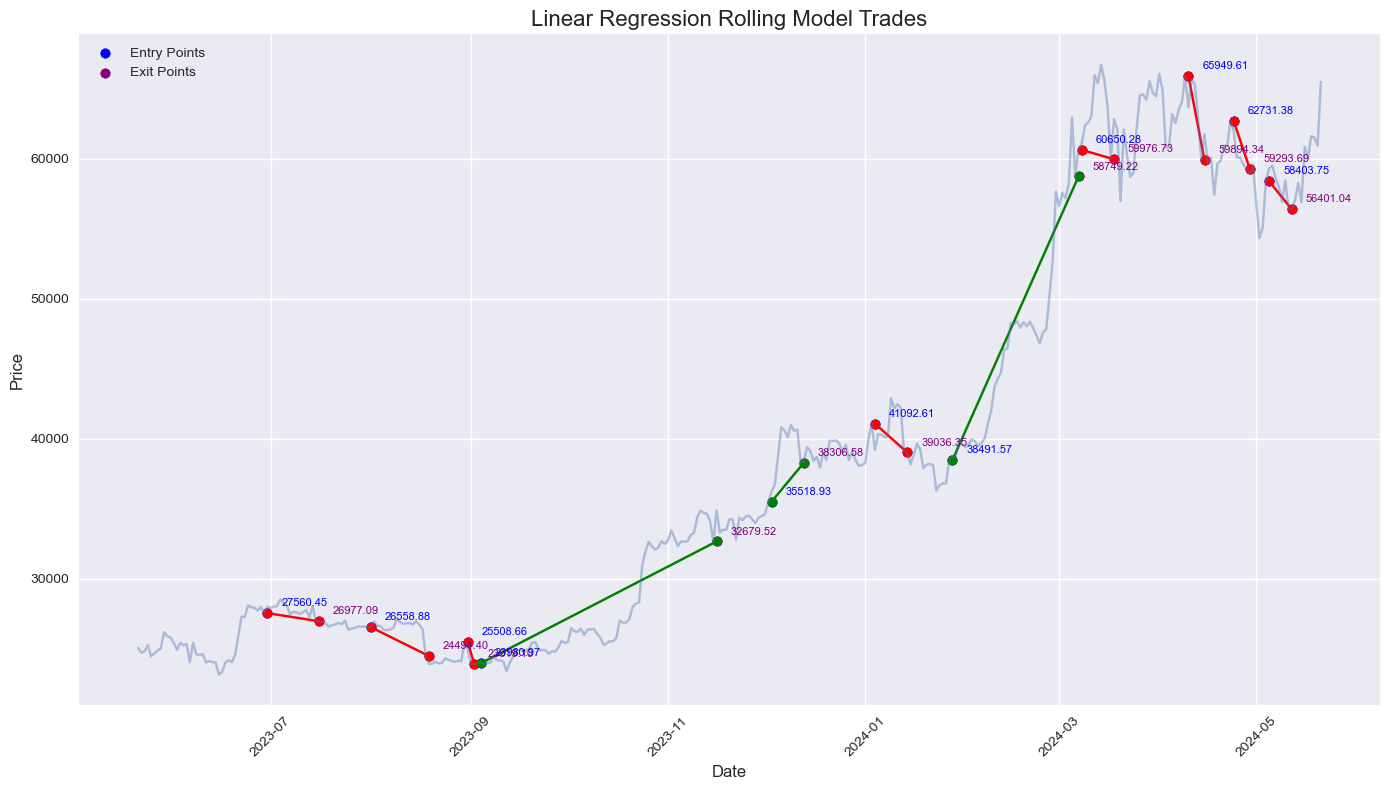

In [61]:
showtrades(trades=best_trades,Close = hist['Close'],title="Linear Regression Rolling Model Trades",annot=True)

### Global  Model with Lagged Features:

In this approach, you're training a single linear model on the entire dataset, including lagged features. Each observation includes not only the current data point (Xt) but also lagged features (Xt-1, Xt-2, ..., Xt-w).

**Xt = f(Xt-1,Xt-2...,Xt-w)**

This approach considers the entire historical context when making predictions, allowing the model to capture longer-term dependencies and complex relationships between features.
However, this approach may suffer from overfitting if the dataset is large or if there are too many lagged features. It also assumes that the relationship between features and target remains stationary over time, which may not always be the case.

In [69]:
def lagged_model(hist,window):
    df = hist['Close'].to_frame()
    for i in range(1,window+1):
        df[f'Lag_{i}'] = df['Close'].shift(i) 
    return df

def signals(hist,input_reg, model, ratio):
    df = hist.copy()
    X = input_reg.drop(['Close'],axis=1)
    y = input_reg['Close']

    ratio = 0.2
    size = len(input_reg)
    treshold = int(size*ratio)

    X_train, y_train = X.iloc[treshold:],y.iloc[treshold:]
    X_test , y_test = X.iloc[:treshold], y.iloc[:treshold]
    reg = model.fit(X_train, y_train)
    prediction = model.predict(X)

    df['Buy'] = np.where(prediction < y,1,0)
    df['Sell'] = np.where(prediction > y,-1,0)
    return df

In [71]:
input_reg = lagged_model(hist,4)
df = signals(hist,input_reg,LinearRegression(),0.2)

ValueError: Length of values (363) does not match length of index (367)

### Classification

In [76]:
hist['Close'].pct_change()